### Setting the Font to look nice for latex

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
font_path = '/Library/Fonts/latinmodern-math.otf' 
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Latin Modern Math'

# Creating the data to test in STATA and Python

### Packaged in a function for ease of use

In [2]:
def create_data(n=1000):

    """
    Create a dataset with endogenous variables and instruments.
    
    Parameters:
    n (int): Number of observations.
    
    Returns:
    DataFrame: A DataFrame containing the generated data.
    """
    # Create many instruments: half as many as n
    num_instruments = n // 2
    Z = np.random.randn(n, num_instruments)
    column_of_ones = np.ones((Z.shape[0], 1))
    Z = np.hstack((column_of_ones, Z))

    # Parameter vectors:
    # Make the coefficients on the instruments (alpha) very small to make instruments weak
    α = np.full(num_instruments + 1, 0.1)  # All coefficients are 0.01 (weak instruments)
    β = np.array([1, 2])

    # Error terms:
    e1 = np.random.normal(0, 6, n)
    e2 = np.random.normal(0, 6, n)
    δ = np.random.normal(0, 1)
    ε = 2 * e1 - 2 * e2 + δ

    # Making our endogenous variable:
    x = np.dot(Z, α) + .2 * e1
    X = np.column_stack((column_of_ones, x))

    # Outcome vector:
    Y = np.dot(X, β) + ε

    return Y, X, Z

### Run the simluation

In [3]:
from ujive1 import *
from ujive2 import *
from tsls import *
from ijive import *
from hful import *
from jive1 import *
from jive2 import *
from lagrange_multiplier import *
from liml import *
from sjive import *
warnings.filterwarnings("ignore")

# Set up the parameters
n_runs = 10
n_sim = 10
n = 1000
true_beta = 2

results = []

for run in range(n_runs):
    beta_ols_list = []
    beta_2sls_list = []
    beta_ujive1_list = []
    beta_ujive2_list = []
    beta_jive1_list = []
    beta_jive2_list = []
    beta_ijive_list = []
    beta_hful_list = []
    beta_liml_list = []
    beta_sjive_list = []
    beta_lm_list = []


    for sim in range(n_sim):
        
        Y, X, Z = create_data(n=n)

        # OLS
        bhat_ols = np.linalg.inv(X.T @ X) @ X.T @ Y
        beta_ols_list.append(bhat_ols[1])

        # 2SLS
        Zt_Z = Z.T @ Z
        Zt_Z_inv = np.linalg.inv(Zt_Z)
        pz = Z @ Zt_Z_inv @ Z.T
        proj_x = pz @ X
        first = np.linalg.inv(proj_x.T @ X)
        second = proj_x.T @ Y
        bhat_2sls = first @ second
        beta_2sls_list.append(bhat_2sls[1])

        # UJIVE1
        ujive1 = UJIVE1(Y, X, Z, talk=False)
        beta_ujive1_list.append(ujive1.beta[1])

        # UJIVE2
        ujive2 = UJIVE2(Y, X, Z, talk=False)
        beta_ujive2_list.append(ujive2.beta[1])

        # JIVE1
        jive1 = JIVE1(Y, X, Z, talk=False)
        beta_jive1_list.append(jive1.beta)

        # JIVE2
        jive2 = JIVE2(Y, X, Z, talk=False)
        beta_jive2_list.append(jive2.beta[1])

        # IJIVE
        #ijive = IJIVE(Y, X, Z, talk=False)
        #beta_ijive_list.append(ijive.beta[1])

        # HFUL
        hful = HFUL(Y, X, Z, talk=False)
        beta_hful_list.append(hful.betas[1])

        # LIML
        #liml = LIML(Y, X, Z, talk=False)
        #beta_liml_list.append(liml.betas[1])

        # SJIVE
        sjive = SJIVE(Y, X, Z, talk=False)
        beta_sjive_list.append(sjive.beta[1])


    # Compute statistics for this run
    for name, estimates in zip(
        ['OLS', '2SLS', 'UJIVE1', 'UJIVE2', 'JIVE1', 'JIVE2', 'HFUL', 'LIML', 'SJIVE'], # IJIVE, LIML are missing
        [beta_ols_list, beta_2sls_list, beta_ujive1_list, beta_ujive2_list, beta_jive1_list, beta_jive2_list, beta_hful_list, beta_sjive_list]
    ):
        estimates = np.array(estimates)
        bias = np.mean(estimates - true_beta)
        variance = np.var(estimates)
        mse = np.mean((estimates - true_beta) ** 2)
        results.append({
            'run': run + 1,
            'estimator': name,
            'bias': bias,
            'variance': variance,
            'mse': mse
        })

In [4]:
# Save results to DataFrame
results_df = pd.DataFrame(results)

#display(results_df.round(4))
display(results_df.groupby('estimator')['bias'].describe().round(4).drop(columns=['count']))
display(results_df.groupby('estimator')['variance'].describe().round(4).drop(columns=['count']))
display(results_df.groupby('estimator')['mse'].describe().round(4).drop(columns=['count']))


import os

# Ensure the figures directory exists
os.makedirs("figures", exist_ok=True)

for metric in ['bias', 'variance', 'mse']:
    summary = results_df.groupby('estimator')[metric].describe().drop(columns=['count'])
    # Format all numbers to 4 digits after the decimal, no trailing zeros
    summary = summary.applymap(lambda x: f"{x:.4f}")
    # Capitalize all column headers
    summary.columns = [col.upper() for col in summary.columns]
    summary.index.name = summary.index.name.capitalize() if summary.index.name else None
    n_cols = summary.shape[1] + 1  # +1 for the index column
    col_format = 'l' + 'r' * (n_cols - 1)
    # Capitalize the first letter of each word in the table title
    table_title = f"{metric} summary by estimator".title()
    latex_table = f"\\begin{{table}}[ht]\n\\centering\n\\caption{{{table_title}}}\n"
    latex_str = summary.to_latex(escape=False, column_format=col_format)
    latex_str = latex_str.replace('%', '\\%')
    latex_table += latex_str
    latex_table += "\\end{table}\n"
    # Save to file
    with open(f"../figures/{metric}_table.tex", "w") as f:
        f.write(latex_table)
    print(f"Saved LaTeX table to figures/{metric}_table.tex")

,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,1.2370,0.0649,1.1182,1.1864,1.2520,1.2846,1.3281
HFUL,-0.0352,0.0670,-0.1531,-0.0591,-0.0269,0.0050,0.0628
JIVE1,-0.4645,0.0512,-0.5347,-0.5079,-0.4609,-0.4246,-0.3839
JIVE2,1.0266,0.1087,0.8789,0.9357,1.0463,1.0973,1.2044
LIML,-0.0400,0.0666,-0.1567,-0.0670,-0.0296,0.0025,0.0571
OLS,2.2279,0.0788,2.0810,2.1805,2.2276,2.2845,2.3461
UJIVE1,-0.0468,0.0638,-0.1260,-0.1020,-0.0348,-0.0036,0.0596
UJIVE2,-0.0499,0.0647,-0.1337,-0.1056,-0.0346,-0.0067,0.0592


,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,0.0332,0.0166,0.0033,0.0216,0.0343,0.0494,0.0512
HFUL,0.0584,0.0264,0.0081,0.0420,0.0597,0.0715,0.0960
JIVE1,0.0501,0.0196,0.0162,0.0378,0.0542,0.0575,0.0783
JIVE2,0.2092,0.0808,0.0803,0.1588,0.2161,0.2578,0.3249
LIML,0.0579,0.0259,0.0084,0.0431,0.0592,0.0701,0.0933
OLS,0.0248,0.0110,0.0084,0.0146,0.0293,0.0341,0.0358
UJIVE1,0.0730,0.0294,0.0227,0.0504,0.0780,0.0915,0.1197
UJIVE2,0.0738,0.0303,0.0227,0.0517,0.0775,0.0905,0.1222


,mean,std,min,25%,50%,75%,max
estimator,,,,,,,
2SLS,1.5671,0.1646,1.2851,1.4326,1.6036,1.6996,1.7866
HFUL,0.0637,0.0272,0.0125,0.0440,0.0684,0.0871,0.0961
JIVE1,0.2682,0.0492,0.1955,0.2397,0.2658,0.3066,0.3440
JIVE2,1.2738,0.2498,0.9551,1.0742,1.2684,1.4507,1.6700
LIML,0.0635,0.0264,0.0141,0.0450,0.0688,0.0858,0.0934
OLS,4.9939,0.3512,4.3584,4.7704,4.9844,5.2535,5.5386
UJIVE1,0.0788,0.0293,0.0258,0.0594,0.0799,0.1021,0.1199
UJIVE2,0.0801,0.0300,0.0256,0.0602,0.0793,0.1047,0.1225


Saved LaTeX table to figures/bias_table.tex
Saved LaTeX table to figures/variance_table.tex
Saved LaTeX table to figures/mse_table.tex


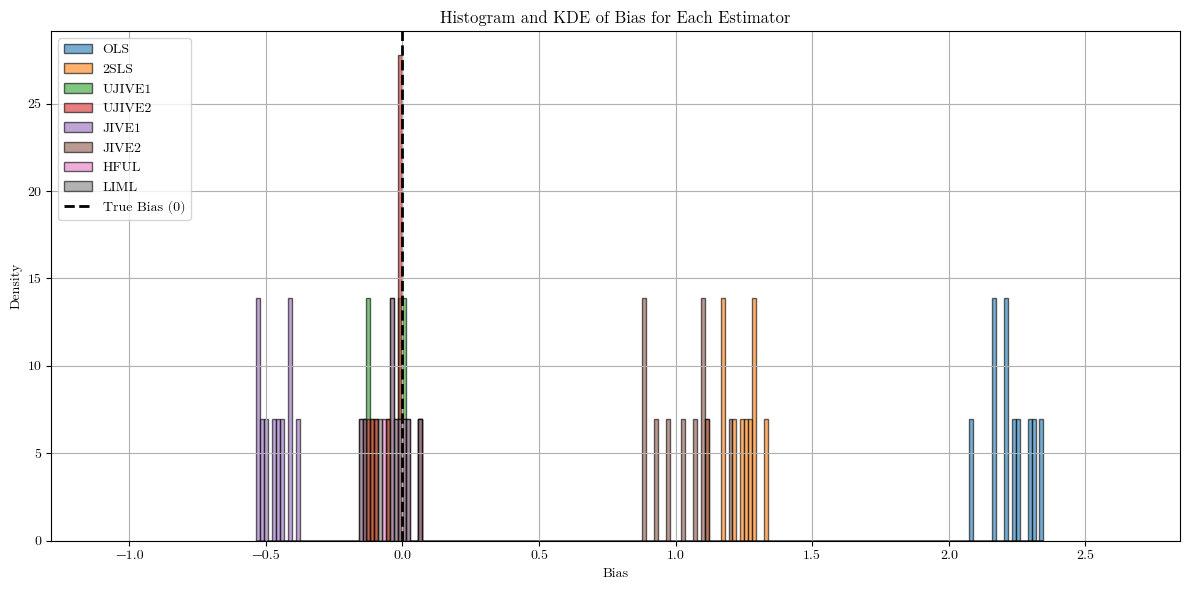

In [5]:
import seaborn as sns

plt.figure(figsize=(12, 6))

# Get unique estimators and assign a unique color to each
estimators = results_df['estimator'].unique()
palette = sns.color_palette("tab10", n_colors=len(estimators))
color_map = {est: palette[i] for i, est in enumerate(estimators)}

# Calculate global bin edges so all histograms use the same bins
all_biases = results_df['bias']
bin_count = 200
bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)

for estimator in estimators:
    subset = results_df[results_df['estimator'] == estimator]
    color = color_map[estimator]
    # Plot histogram (barplot) with matching color and fixed bins
    plt.hist(
        subset['bias'],
        bins=bin_edges,
        alpha=0.6,
        label=estimator,
        edgecolor='black',
        linewidth=1,
        density=True,
        color=color
    )

plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
plt.xlabel('Bias')
plt.ylabel('Density')
plt.title('Histogram and KDE of Bias for Each Estimator')
plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
plt.legend(frameon=True, loc='upper left')
plt.grid(True)
plt.tight_layout()
#plt.savefig("../figures/bias_plot.png", dpi=900, bbox_inches='tight')
plt.show()

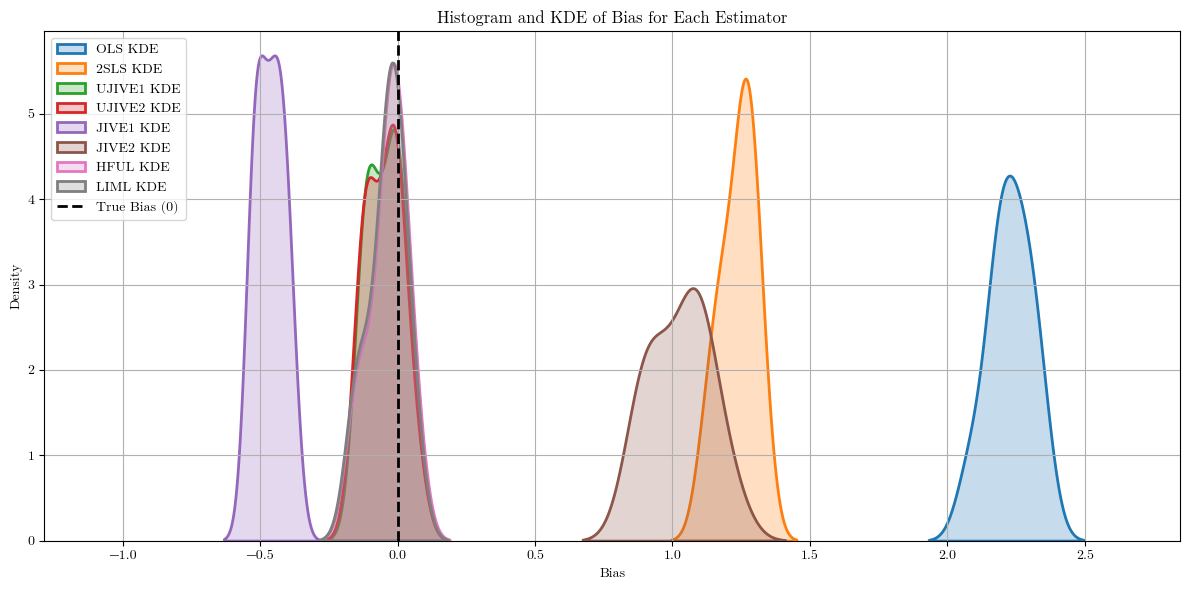

In [6]:
plt.figure(figsize=(12, 6))

# Get unique estimators and assign a unique color to each
estimators = results_df['estimator'].unique()
palette = sns.color_palette("tab10", n_colors=len(estimators))
color_map = {est: palette[i] for i, est in enumerate(estimators)}

# Calculate global bin edges so all histograms use the same bins
all_biases = results_df['bias']
bin_count = 200
bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)


for estimator in estimators:
    subset = results_df[results_df['estimator'] == estimator]
    color = color_map[estimator]
    # Plot KDE curve with the same color
    sns.kdeplot(
        subset['bias'],
        label=f"{estimator} KDE",
        linewidth=2,
        color=color,
        fill=True,
    )

plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
plt.xlabel('Bias')
plt.ylabel('Density')
plt.title('Histogram and KDE of Bias for Each Estimator')
plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
plt.legend(frameon=True, loc='upper left')
plt.grid(True)
plt.tight_layout()
#plt.savefig("../figures/bias_plot.png", dpi=900, bbox_inches='tight')
plt.show()

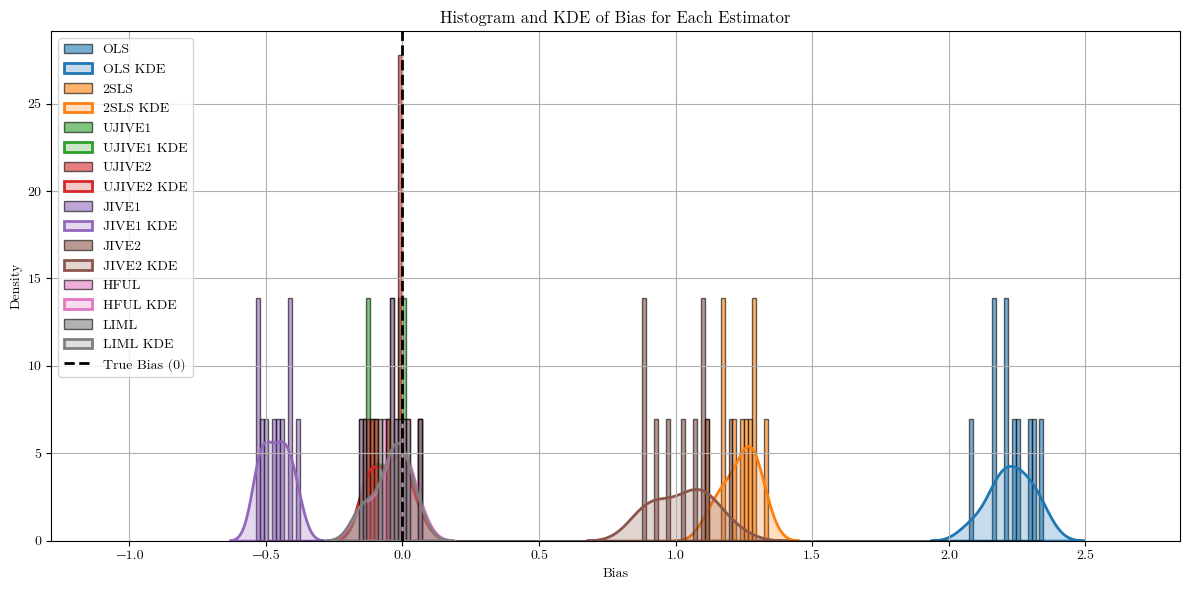

In [7]:
import seaborn as sns

plt.figure(figsize=(12, 6))

# Get unique estimators and assign a unique color to each
estimators = results_df['estimator'].unique()
palette = sns.color_palette("tab10", n_colors=len(estimators))
color_map = {est: palette[i] for i, est in enumerate(estimators)}

# Calculate global bin edges so all histograms use the same bins
all_biases = results_df['bias']
bin_count = 200
bin_edges = np.histogram_bin_edges(all_biases, bins=bin_count)

for estimator in estimators:
    subset = results_df[results_df['estimator'] == estimator]
    color = color_map[estimator]
    # Plot histogram (barplot) with matching color and fixed bins
    plt.hist(
        subset['bias'],
        bins=bin_edges,
        alpha=0.6,
        label=estimator,
        edgecolor='black',
        linewidth=1,
        density=True,
        color=color
    )
    # Plot KDE curve with the same color
    sns.kdeplot(
        subset['bias'],
        label=f"{estimator} KDE",
        linewidth=2,
        color=color,
        fill=True,
    )

plt.axvline(0, color='k', linestyle='dashed', linewidth=2, label='True Bias (0)')
plt.xlabel('Bias')
plt.ylabel('Density')
plt.title('Histogram and KDE of Bias for Each Estimator')
plt.xlim(all_biases.min()-0.75, all_biases.max()+0.5)
plt.legend(frameon=True, loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/bias_plot.png", dpi=900, bbox_inches='tight')
plt.show()

### Black and White version

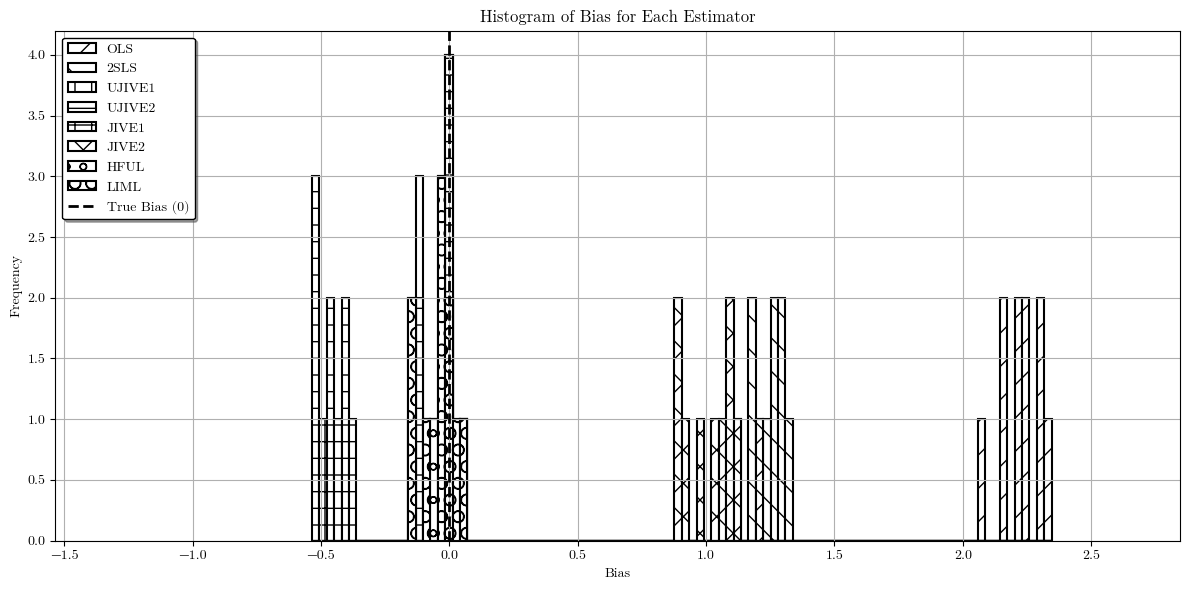

In [8]:
import matplotlib.pyplot as plt

true_beta = 2
bin_count = 100

all_biases = results_df['bias']
bin_range = (all_biases.min(), all_biases.max())

plt.figure(figsize=(12, 6))
hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
for i, estimator in enumerate(results_df['estimator'].unique()):
    subset = results_df[results_df['estimator'] == estimator]
    plt.hist(
        subset['bias'],
        bins=bin_count,
        range=bin_range,
        alpha=1.0,
        label=estimator,
        color='white',
        edgecolor='black',
        linewidth=1.5,
        hatch=hatch_patterns[i % len(hatch_patterns)]
    )

plt.axvline(0, color='black', linestyle='dashed', linewidth=2, label='True Bias (0)')
plt.xlabel('Bias')
plt.xlim(all_biases.min() - 1, all_biases.max()+0.5)
plt.ylabel('Frequency')
plt.title('Histogram of Bias for Each Estimator')
plt.legend(frameon=True, loc='upper left', fancybox=True, shadow=True, edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/bias_plot_bw.png", dpi=300, bbox_inches='tight')
plt.show()

# Old DGP just in case

In [9]:
"""#Pick a vector length:
n = 1000

#Getting our Z's and making a Z matrix:
Z = np.random.randn(n, 1)
column_of_ones = np.ones((Z.shape[0], 1))
Z = np.hstack((column_of_ones, Z))
#pprint(Z)

#Parameter vectors:
α = np.array([1,1])
β = np.array([1,2])
#pprint(α)
#pprint(β)

#Error terms:
e1 = np.random.normal(0,5,n)
e2 = np.random.normal(0,5,n)
δ = np.random.normal(0,1)
ε = 2*e1 - 2*e2 + δ

#Making our endogenous variable:
x = np.dot(Z,α) + .2*e1
X = np.column_stack((column_of_ones, x))
#pprint(X)

#Outcome vector:
Y = np.dot(X,β) + ε

#OLS benchmark:
bhat_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T, Y))

# Check to see if the Z'Z matrix is invertible
if np.linalg.matrix_rank(Z.T @ Z) == Z.shape[1]:  # Should be True
    print("Z'Z is invertible")
else:
    print("Z'Z is not invertible")

cond_number = np.linalg.cond(Z.T @ Z)
print(f"Condition number of Z.T @ Z: {cond_number}")
if cond_number > 1e10:  # Threshold for ill-conditioning
    raise ValueError("Z.T @ Z is ill-conditioned and may cause numerical instability.")


#2sls comparison:
Zt_Z = np.dot(Z.T, Z)
Zt_Z_inv = np.linalg.inv(Zt_Z)
pz = np.dot(np.dot(Z, Zt_Z_inv), Z.T)
proj_x = np.dot(pz, X)
first = np.linalg.inv(np.dot(proj_x.T, X))
second = np.dot(proj_x.T, Y)
bhat_2sls = np.dot(first, second)


ujive1 = UJIVE1(Y,X,Z,talk=False)
ujive2 = UJIVE2(Y,X,Z,talk=False)
tsls = TSLS(Y,X,Z, talk=False)

# Combine matrices into a single DataFrame
df = pd.DataFrame({
    "Y": Y,  # Outcome vector
    **{f"X{i}": X[:, i] for i in range(X.shape[1])},  # Endogenous variables
    **{f"Z{i}": Z[:, i] for i in range(Z.shape[1])}   # Instrumental variables
})

# Save the DataFrame to a CSV file
df.to_csv('data.csv', index=False)

#Compare them:
print("OLS:", bhat_ols[1])
print("2SLS:", bhat_2sls[1])"""

'#Pick a vector length:\nn = 1000\n\n#Getting our Z\'s and making a Z matrix:\nZ = np.random.randn(n, 1)\ncolumn_of_ones = np.ones((Z.shape[0], 1))\nZ = np.hstack((column_of_ones, Z))\n#pprint(Z)\n\n#Parameter vectors:\nα = np.array([1,1])\nβ = np.array([1,2])\n#pprint(α)\n#pprint(β)\n\n#Error terms:\ne1 = np.random.normal(0,5,n)\ne2 = np.random.normal(0,5,n)\nδ = np.random.normal(0,1)\nε = 2*e1 - 2*e2 + δ\n\n#Making our endogenous variable:\nx = np.dot(Z,α) + .2*e1\nX = np.column_stack((column_of_ones, x))\n#pprint(X)\n\n#Outcome vector:\nY = np.dot(X,β) + ε\n\n#OLS benchmark:\nbhat_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T, Y))\n\n# Check to see if the Z\'Z matrix is invertible\nif np.linalg.matrix_rank(Z.T @ Z) == Z.shape[1]:  # Should be True\n    print("Z\'Z is invertible")\nelse:\n    print("Z\'Z is not invertible")\n\ncond_number = np.linalg.cond(Z.T @ Z)\nprint(f"Condition number of Z.T @ Z: {cond_number}")\nif cond_number > 1e10:  # Threshold for ill-conditioning\n